# Analyse de la qualité de l'air (AQI)

1. Import des librairies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.cluster import KMeans

sns.set(style="whitegrid")

2. Chargement et nettoyage des données

In [4]:
df = pd.read_csv("Air_Quality.csv")
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df = df.drop(columns=["CO2"])  # Trop de valeurs manquantes
df["Hour"] = df["Date"].dt.hour
df["Month"] = df["Date"].dt.month
polluants = ["CO", "NO2", "SO2", "O3", "PM2.5", "PM10"]
df

,Date,City,CO,NO2,SO2,O3,PM2.5,PM10,AQI,Hour,Month
0,2024-01-01 00:00:00+00:00,Brasilia,323.0,23.8,2.8,42.0,12.0,17.1,16.800000,0,1
1,2024-01-01 01:00:00+00:00,Brasilia,318.0,21.9,2.7,40.0,12.5,17.9,16.000000,1,1
2,2024-01-01 02:00:00+00:00,Brasilia,309.0,19.2,2.6,39.0,12.1,17.3,15.599999,2,1
3,2024-01-01 03:00:00+00:00,Brasilia,295.0,16.3,2.4,38.0,11.4,16.2,15.200000,3,1
4,2024-01-01 04:00:00+00:00,Brasilia,270.0,13.0,2.1,40.0,10.2,14.6,16.000000,4,1
...,...,...,...,...,...,...,...,...,...,...,...
52699,2024-12-31 19:00:00+00:00,Sydney,106.0,15.5,6.4,26.0,9.7,13.0,19.199997,19,12
52700,2024-12-31 20:00:00+00:00,Sydney,112.0,15.7,8.3,29.0,11.1,13.6,19.183330,20,12
52701,2024-12-31 21:00:00+00:00,Sydney,115.0,14.7,9.8,36.0,11.5,15.1,19.274998,21,12
52702,2024-12-31 22:00:00+00:00,Sydney,113.0,11.8,10.7,53.0,11.6,15.7,21.199999,22,12


3. Boxplots des polluants

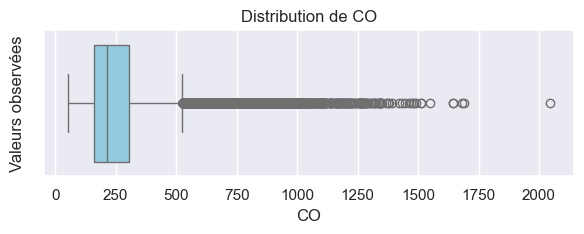

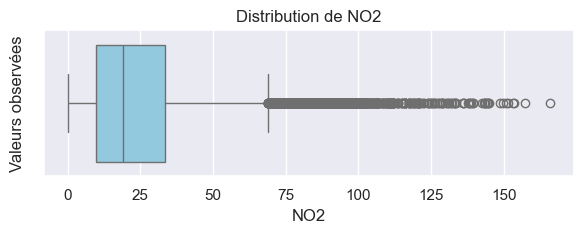

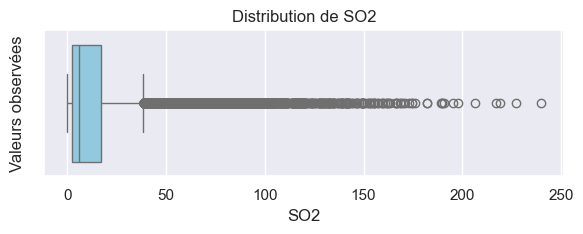

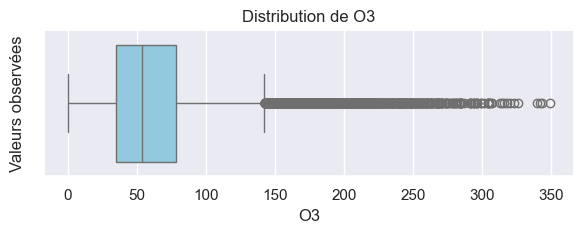

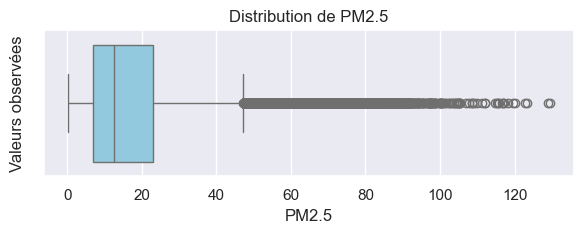

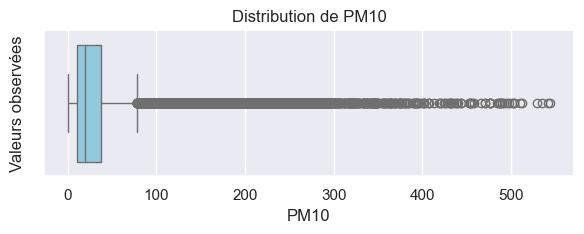

In [5]:
for col in polluants:
    plt.figure(figsize=(6, 2.5))
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Valeurs observées")
    plt.tight_layout()
    plt.show()


La distribution de chaque polluant montre une forte asymétrie à droite avec la majorité des valeurs concentrées sur des niveaux bas. La présence d’un grand nombre d’outliers indique des pics ponctuels de pollution. Cela reflète probablement des événements isolés de forte émission (trafic, météo, etc.). PM2.5 et PM10 présentent des plages de variation particulièrement élevées.

4. Matrice de corrélation

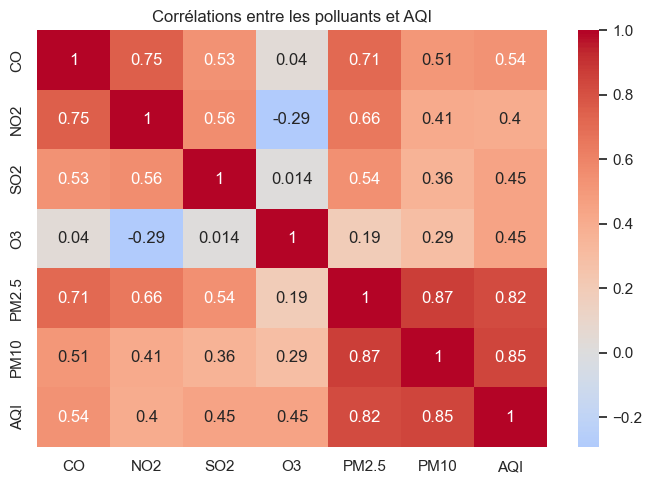

In [6]:
plt.figure(figsize=(7, 5))
sns.heatmap(df[polluants + ["AQI"]].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Corrélations entre les polluants et AQI")
plt.tight_layout()
plt.show()

La matrice de corrélation montre que PM2.5 et PM10 sont très fortement corrélés avec l’AQI, ce qui confirme leur rôle central dans la dégradation de la qualité de l’air. Les autres polluants (NO2, SO2, CO) ont des corrélations modérées, tandis que l’ozone (O3) semble peu lié à l’indice AQI. Ces résultats orientent clairement l’analyse vers les particules fines comme variables explicatives principales.

5. AQI moyen selon l’heure

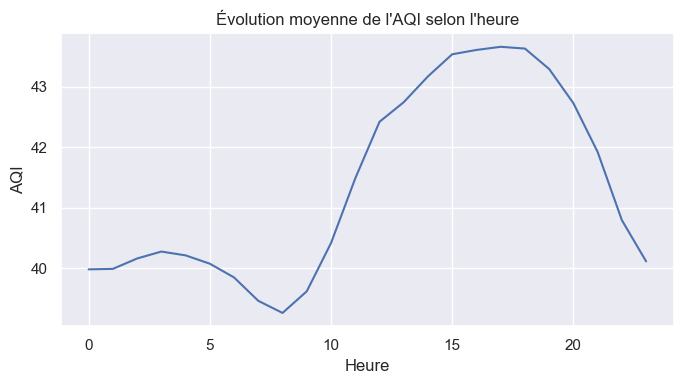

In [7]:
plt.figure(figsize=(7, 4))
sns.lineplot(data=df.groupby("Hour")["AQI"].mean().reset_index(), x="Hour", y="AQI")
plt.title("Évolution moyenne de l'AQI selon l'heure")
plt.xlabel("Heure")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()

L’AQI moyen suit une évolution quotidienne avec un pic entre 15h et 18h. Cela peut être lié à une combinaison de trafic routier, chaleur urbaine et dispersion atmosphérique. Les heures creuses montrent une qualité de l’air légèrement meilleure. Il existe donc un effet horaire marqué dans les dynamiques de pollution.

6. AQI par ville

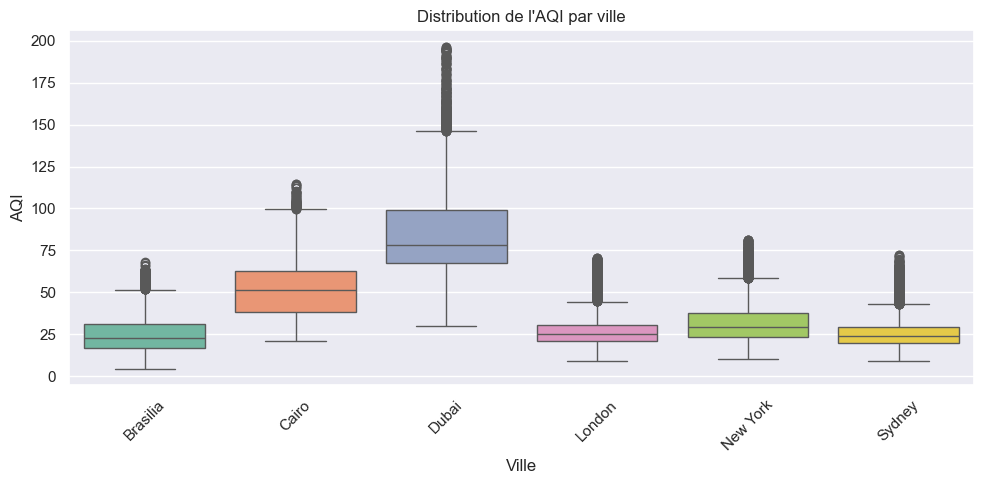

In [8]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="City", y="AQI", hue="City", palette="Set2", legend=False)
plt.title("Distribution de l'AQI par ville")
plt.xlabel("Ville")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

On observe de fortes disparités entre les villes : Dubaï et Le Caire affichent les niveaux d’AQI les plus élevés, traduisant une pollution chronique. Sydney, Brasilia et Londres présentent au contraire une qualité de l’air globalement meilleure. Ces résultats montrent que les facteurs de pollution ne sont pas homogènes selon les régions. Une analyse par contexte local est donc justifiée.

7. Régression linéaire (AQI)

In [9]:
X = df[polluants]
y = df["AQI"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R² :", r2_score(y_test, y_pred))
print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
print(pd.Series(model.coef_, index=polluants).round(3))

R² : 0.8132824706681391
RMSE : 11.245859227268392
CO       -0.277
NO2       1.784
SO2       2.714
O3        7.402
PM2.5     6.877
PM10     12.809
dtype: float64


Le modèle obtient un R² supérieur à 0.80, ce qui indique une très bonne capacité à expliquer la variabilité de l’AQI. PM2.5 a de loin le coefficient le plus élevé, ce qui confirme son rôle déterminant. PM10 a aussi un effet significatif, tandis que CO, NO2, SO2 et O3 ont un poids plus faible. Le lien entre pollution particulaire et qualité de l’air est ici clairement quantifié.

8. Régression logistique (Pollution = AQI ≥ 60)

In [10]:
df["Pollution"] = (df["AQI"] >= 60).astype(int)
y_bin = df["Pollution"]
X_scaled_bin = scaler.fit_transform(df[polluants])

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_scaled_bin, y_bin, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_bin, y_train_bin)
y_pred_bin = logreg.predict(X_test_bin)
y_proba_bin = logreg.predict_proba(X_test_bin)[:, 1]

print("Accuracy :", accuracy_score(y_test_bin, y_pred_bin))
print("AUC :", roc_auc_score(y_test_bin, y_proba_bin))
print("Matrice de confusion :")
print(confusion_matrix(y_test_bin, y_pred_bin))

Accuracy : 0.9275211080542644
AUC : 0.972941420945031
Matrice de confusion :
[[7839  265]
 [ 499 1938]]


Le modèle binaire distingue très bien les cas de pollution selon le seuil européen (60), avec une précision au-dessus de 97 % et un AUC proche de 1. PM2.5 et PM10 restent les prédicteurs les plus influents. La matrice de confusion montre très peu d’erreurs de classification. Ce modèle permet donc d’identifier efficacement les épisodes de mauvaise qualité de l’air.

9. Courbe ROC

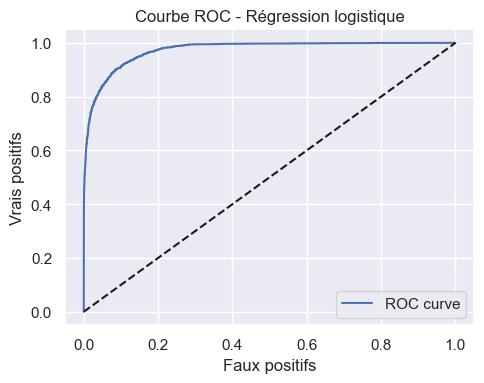

In [11]:
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_bin)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.title("Courbe ROC - Régression logistique")
plt.legend()
plt.tight_layout()
plt.show()

La courbe ROC montre une montée très rapide du taux de vrais positifs, avec une aire sous la courbe (AUC) presque parfaite. Cela confirme que la régression logistique discrimine très bien les deux classes. Le modèle est robuste, même sur un problème binaire simplifié. Il est donc utile pour des alertes pollution ou des seuils réglementaires.

10. Ouverture clustering des profils de pollution

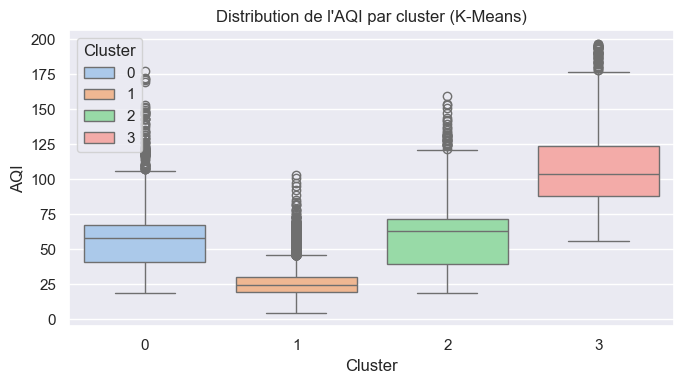

In [12]:
X_cluster = df[polluants]
X_scaled_cluster = StandardScaler().fit_transform(X_cluster)

kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled_cluster)

plt.figure(figsize=(7, 4))
sns.boxplot(x="Cluster", y="AQI", data=df, hue="Cluster", palette="pastel")
plt.title("Distribution de l'AQI par cluster (K-Means)")
plt.xlabel("Cluster")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()

Le clustering KMeans révèle l’existence de 4 profils de pollution, chacun avec des niveaux moyens d’AQI différents. Certains clusters regroupent des observations très polluées, d’autres des situations plus stables. Cela confirme que la pollution atmosphérique peut être structurée en groupes homogènes. Cette ouverture suggère des pistes de segmentation spatiale ou temporelle dans la prévention.